In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from utils.clean_functions import *
from utils.hypothesis_functions import *


## INFORMACIÓN DEL PROYECTO

### Título

La guerra de Ucrania: precios, bajas y refugiados


### Tema

Es una comparativa de 6 datasets de tamaños variables sobre diversos aspectos de la guerra de Ucrania que tienen que ver con las pérdidas (sobre todo, las rusas, de las que hay más datos disponibles), los refugiados y los precios en los mercados locales. El nexo de la mayoría son las fechas. Las hipótesis son:

1) Los precios en Ucrania oscilan en función del número de refugiados huidos del país (cuantos más hay, menos demanda) y de la cercanía al frente de los puestos de venta (cuanto más cerca están, más caro es transportar los productos). Asimismo, un peor rendimiento por parte del bando ruso debe de animar a los proveedores extranjeros a vender en el país y aumentar la oferta (con lo cual los productos son más baratos).

A modo de esquema, se puede resumir así:

(Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos)

2) Con el paso del tiempo, aumentan las pérdidas materiales rusas y se reducen las humanas. Ello es indicativo de una creciente preocupación de la administración rusa por la opinión pública, con lo que, entre otras cosas, se sirve menos de soldados de a pie para minimizar la cuenta de bajas.

A modo de esquema, se puede resumir así:

[Uso mayor de tropas mecanizadas = uso reducido de soldados rasos = más pérdidas materiales y menos muertos]

3) Los ejércitos ruso y ucraniano utilizan mucho material de la Unión Soviética, que, en comparación con el equipamiento moderno, tiende a capturarse con mayor frecuencia.

A modo de esquema, se puede resumir así:

[Uso de material soviético = más destrucciones y más capturas]

### Obtención de datos

El origen de cada dataset, junto con la fuente original y los datos que se le requieren, es el siguiente:

- Acumulado de refugiados ucranianos por fecha y destino (fuente original: API sobre actualizaciones de la guerra de RapidAPI):
https://www.kaggle.com/datasets/anuragbantu/ukraine-invasion-refugee-data-2022

- Precios en cada mercado de Ucrania por fecha, tipo y geolocalización (fuente original: Centre for Humanitarian Data de la Oficina de Naciones Unidas para la Coordinación de Asuntos Humanitarios):
https://data.humdata.org/dataset/wfp-food-prices-for-ukraine

- Pérdidas rusas personales por fecha (fuente original: múltiples, ver en Kaggle; entre ellas, el Ejército y el Ministerio de Defensa del Ucrania):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war
- Pérdidas rusas materiales, según categorías generales, por fecha (fuente original: la misma, pues sale del mismo Kaggle que el anterior).

- Pérdidas rusas materiales, incluyendo modelo y fabricante, sin fecha (fuente original: Oryxspioenkop, web alemana de análisis datos de defensa de código abierto e investigación sobre la guerra):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russia-war-equipment-losses-oryx
-	Pérdidas ucranianas materiales, incluyendo modelo y fabricante, sin fecha (fuente original: la misma, pues sale mismo Kaggle que el anterior).


## LIMPIEZA

### df_refugees (acumulado de refugiados ucranianos por fecha y destino)

- Importo el dataframe i veo que no tiene nulos

In [3]:
df_refugees = pd.read_csv(r'.\data\Refugees.csv')

df_refugees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    665 non-null    int64  
 1   id            665 non-null    object 
 2   country       665 non-null    object 
 3   date          665 non-null    object 
 4   individuals   665 non-null    int64  
 5   centroid_lon  665 non-null    float64
 6   centroid_lat  665 non-null    float64
 7   lat_max       665 non-null    float64
 8   lon_max       665 non-null    float64
 9   lan_min       665 non-null    float64
 10  lon_min       665 non-null    float64
 11  source        665 non-null    object 
dtypes: float64(6), int64(2), object(4)
memory usage: 62.5+ KB


- Creo una función que convierte la columna de fechas ("date") en un datetime ordenado (index_by_datetime) y lo lleva al índice, lo cual me será útil si tengo que unificar tablas
- Dejo solo las columnas de país ("country") y acumulado de refugiados ("individuals"). Las demás no me interesan para la hipótesis


In [4]:
index_by_datetime(df_refugees)

df_refugees = df_refugees[['country','individuals']]


- Compruebo que hay varios países que aparecen bastante menos que los demás. Sin embargo, como todavía no he igualado esta tabla a la otra necesaria para la hipótesis (es decir, la de precios), no tengo claro qué meses voy a necesitar ni qué días de esos meses serán el mejor punto de referencia (por aparecer en la otra tabla). Por tanto, de momento, los dejo todos sin tocarlos

In [5]:
df_refugees['country'].value_counts()


Hungary                     106
Slovakia                    105
Poland                      102
Republic of Moldova         102
Romania                      93
Belarus                      76
Russian Federation           70
Other European countries     11
Name: country, dtype: int64

- Resultado:

In [6]:
df_refugees.head()


,country,individuals
date,,
2022-03-01,Belarus,341
2022-03-01,Poland,453982
2022-03-01,Hungary,116348
2022-03-01,Republic of Moldova,79315
2022-03-01,Russian Federation,42900


### df_prices (precios en cada mercado de Ucrania por fecha, tipo y geolocalización)

- Importo el dataframe y veo que hay algunos nulos

In [7]:
df_prices = pd.read_csv(r'.\data\Prices.csv', low_memory=False)

df_prices.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70731 entries, 0 to 70730
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       70731 non-null  object
 1   admin1     69685 non-null  object
 2   admin2     69685 non-null  object
 3   market     70731 non-null  object
 4   latitude   69685 non-null  object
 5   longitude  69685 non-null  object
 6   category   70731 non-null  object
 7   commodity  70731 non-null  object
 8   unit       70731 non-null  object
 9   priceflag  70731 non-null  object
 10  pricetype  70731 non-null  object
 11  currency   70731 non-null  object
 12  price      70731 non-null  object
 13  usdprice   70731 non-null  object
dtypes: object(14)
memory usage: 7.6+ MB


- Solo con mirar la cabecera de la tabla, y teniendo en cuenta que hay el mismo número de nulos en "admin1", "admin2", "latitude" y "longitude", salta a la vista que probablemente correspondan todos al valor de "market" llamado "National Average". Esa media no me interesa para el análisis

In [8]:
df_prices.head()


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Bread (rye),Loaf,actual,Retail,UAH,4.96,0.135
2,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Bread (wheat),Loaf,actual,Retail,UAH,4.84,0.1318
3,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Buckwheat grits,KG,actual,Retail,UAH,7.44,0.2026
4,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Potatoes,KG,actual,Retail,UAH,6.74,0.1835


- Leo el índice 0, puramente explicativo, el cual hay que quitar. Las columnas "admin1" y "admin2" son nombres de calles y ciudades, probablemente de donde Naciones Unidas ha recibido los datos... no me interesan, y, además, están incompletas. La de "latitude" tampoco me hace falta, porque para estimar la cercanía al frente me basta el plano horizontal ("longitude", que es la longitud este; cuanto más hacia el este se sitúa una ciudad, más cerca del frente se encuentra). Las columnas desde "priceflag" a "currency" tampoco las quiero, porque todos sus valores son iguales
- Elimino todas las filas donde el mercado sea, en realidad, la media nacional ("National Average")
- Cambio a numéricas las columnas "longitude", "usdprice" y "price"
- Aplico la función que me pone la fecha, en forma de datetime, como índice (index_by_datetime)

In [9]:
df_prices = df_prices.drop(index=0, columns=['admin1', 'admin2', 'latitude', 'priceflag','pricetype', 'currency'])
df_prices = df_prices[df_prices['market'] != 'National Average']

df_prices[['usdprice', 'longitude', 'price']] = df_prices[['usdprice', 'longitude', 'price']].apply(pd.to_numeric, errors='coerce', axis=1)

index_by_datetime(df_prices)


- Limito el dataframe al período de la guerra con Russia
- Compruebo que con todo lo hecho ya no hay nulos

In [10]:
start_war = datetime.datetime(2022, 2, 24, 0, 0, 0)
df_prices = df_prices[df_prices.index >= start_war]

df_prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6084 entries, 2022-03-15 to 2022-09-15
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   market     6084 non-null   object 
 1   longitude  6084 non-null   float64
 2   category   6084 non-null   object 
 3   commodity  6084 non-null   object 
 4   unit       6084 non-null   object 
 5   price      6084 non-null   float64
 6   usdprice   6084 non-null   float64
dtypes: float64(3), object(4)
memory usage: 380.2+ KB


- Ahora debo elegir qué productos (en "commodity") me sirven para comparar las oscilaciones de precios en función de las bajas, los refugiados o la lejanía al frente. Empiezo por hacer un test ANOVA; aunque es poco probable, si las medias de todos son iguales, puedo coger cualquiera como producto representativo. En caso contrario, debo usar otros criterios

In [11]:
model = ols('usdprice ~ commodity',
            data = df_prices).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)

print (anova_result)


                 sum_sq      df            F  PR(>F)
commodity  10853.702268    41.0  3243.254352     0.0
Residual     493.166717  6042.0          NaN     NaN


- El ANOVA ha dado negativo (pvalor < 0.05), luego las medias no son iguales. A ver qué opciones de productos hay

In [12]:
df_prices.groupby(['category','commodity','unit']).mean(numeric_only=True)


longitude  \
category              commodity                         unit                    
cereals and tubers    Barley                            KG          29.697836   
                      Bread (first grade flour)         KG          29.708627   
                      Bread (high grade flour)          KG          29.887170   
                      Bread (rye)                       KG          29.837633   
                      Bread (wheat)                     500 G       29.744335   
                      Buckwheat                         KG          29.791636   
                      Millet                            KG          29.592885   
                      Pasta                             KG          29.764351   
                      Potatoes                          KG          29.715131   
                      Rice                              KG          29.733840   
                      Semolina                          KG          29.678158   
                      Wheat flour                       KG          29.731234   
meat, fish and eggs   Eggs                              10 pcs      29.668921   
                      Fish (frozen)                     KG          29.578181   
                      Meat (beef)                       KG          29.714753   
                      Meat (chicken, fillet)            KG          29.674002   
                      Meat (chicken, whole)             KG          29.812812   
                      Meat (mixed, sausage)             KG          29.836801   
                      Meat (pork)                       KG          29.758647   
milk and dairy        Curd                              KG          29.686849   
                      Milk                              KG          29.805724   
                      Sour cream                        KG          29.660928   
miscellaneous food    Sugar                             KG          29.740623   
non-food              Antibiotics (imported)            10 tablets  29.755590   
                      Antibiotics (local)               10 tablets  29.821667   
                      Antipyretic (imported)            1 sachet    29.734824   
                      Antipyretic (local)               10 tablets  29.803447   
                      Fuel (LPG)                        L           29.778417   
                      Fuel (diesel)                     L           29.751170   
                      Fuel (petrol-gasoline, 92 octane) L           29.677596   
                      Fuel (petrol-gasoline, 95 octane) L           29.744148   
                      Transport (public)                1 ticket    30.259450   
                      Vasodilating agents (imported)    10 tablets  29.695691   
                      Vasodilating agents (local)       10 tablets  29.807066   
oil and fats          Butter                            200 G       29.619461   
                      Fat (salo)                        KG          29.700243   
                      Oil (sunflower)                   L           29.725018   
vegetables and fruits Apples                            KG          29.656373   
                      Beetroots                         KG          29.819738   
                      Cabbage                           KG          29.725619   
                      Carrots                           KG          29.882290   
                      Onions                            KG          29.803402   

                                                                         price  \
category              commodity                         unit                     
cereals and tubers    Barley                            KG           19.944615   
                      Bread (first grade flour)         KG           30.790490   
                      Bread (high grade flour)          KG           36.555874   
                      Bread (rye)                       KG           31.765435   
           

- Noto que, en "non-food" los medicamentos vienen en 3 tipos (antibióticos, antipiréticos y agentes vasodilatadores), y que los tres pueden ser locales o importados; ello me ofrece dos dimensiones más para comparar. Además, como en la guerra suele haber más heridos que en períodos de paz, si es cierto que los precios varían de ciudad en ciudad por diferencias en la demanda se verá más claro en el caso de los medicamentos. Así pues, los elijo para mi estudio 


In [13]:
df_prices = df_prices[(df_prices['commodity'].str.contains('imported')) |(df_prices['commodity'].str.contains('local'))]

df_prices.groupby(['category','commodity','unit']).mean(numeric_only=True)


longitude       price  \
category commodity                      unit                                
non-food Antibiotics (imported)         10 tablets  29.755590  172.700507   
         Antibiotics (local)            10 tablets  29.821667   39.405944   
         Antipyretic (imported)         1 sachet    29.734824   22.319392   
         Antipyretic (local)            10 tablets  29.803447   15.647600   
         Vasodilating agents (imported) 10 tablets  29.695691   61.027703   
         Vasodilating agents (local)    10 tablets  29.807066   12.897826   

                                                    usdprice  
category commodity                      unit                  
non-food Antibiotics (imported)         10 tablets  4.701545  
         Antibiotics (local)            10 tablets  1.072780  
         Antipyretic (imported)         1 sachet    0.607618  
         Antipyretic (local)            10 tablets  0.425981  
         Vasodilating agents (imported) 10 tablets  1.661396  
         Vasodilating agents (local)    10 tablets  0.351125

- Hay un problema, sin embargo, y es que los antipiréticos importados vienen en una unidad diferente ("1 sachet" vs "10 tablets"). Por tanto, debo actualizar sus precios para que todos los medicamentos sean comparables
- Hay que encontrar un medicamento que sea antipirético (como el ibuprofeno), importado en Ucrania, y que se venda tanto en "sachets" (bolsitas) como en comprimidos. Tras una búsqueda por páginas de medicamentos ucranianas, encuentro este: https://www-farmaco-ua.translate.goog/catalog/affida-maks-z-argnnom-granuli-dlya-oralnogo-rozchinu-400-mg-sashe-20?_x_tr_sl=uk&_x_tr_tl=en&_x_tr_hl=es&_x_tr_pto=wapp
- Para la versión del medicamento en tabletas, encuentro: https://www-farmaco-ua.translate.goog/catalog/affida-maks-ekspres-kapsuli-m-yak-po-400-mg-po-10-kapsul-m-yakih-u-blster-10?_x_tr_sl=uk&_x_tr_tl=en&_x_tr_hl=es&_x_tr_pto=wapp
- A 217.90 UAH cada 20 sachets, cada satchet sale a 10.895 UAH, que son 0.30 dólares. A 109.30 UAH cada 10 tabletas, cada tableta sale a 10.93 UAH, que son, también, 0.30. Por tanto, 1 sachet = 1 tableta, y hay que multiplicar por 10 todos los valores de "Antypiretic (imported)" para obtener una aproximación razonable que comparar con los demás medicamentos

In [14]:
df_prices.loc[df_prices['commodity'] == 'Antipyretic (imported)', 'usdprice'] = df_prices[df_prices['commodity'] == 'Antipyretic (imported)']['usdprice'] * 10


- Hecha la corrección, elimino las ahora innecesarias columnas de category y unit
- Dejo solo el precio en dólares, ya que me es más cómodo para trabajar por estar acostumbrado a esta unidad

In [15]:
df_prices = df_prices[['market', 'longitude', 'commodity', 'usdprice']]


- Resultado:

In [16]:
df_prices.head()


,market,longitude,commodity,usdprice
date,,,,
2022-03-15,Rivne,26.251617,Antibiotics (imported),4.8148
2022-03-15,Rivne,26.251617,Antibiotics (local),1.0399
2022-03-15,Rivne,26.251617,Antipyretic (local),0.4625
2022-03-15,Rivne,26.251617,Vasodilating agents (local),0.3667
2022-03-15,Rivne,26.251617,Vasodilating agents (imported),1.5907


### df_personnel (pérdidas rusas personales por fecha)

- Importo el dataframe y veo que hay algunos nulos

In [17]:
df_personnel = pd.read_csv(r'.\data\Russia_losses_personnel(date).csv')

df_personnel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        258 non-null    object 
 1   day         258 non-null    int64  
 2   personnel   258 non-null    int64  
 3   personnel*  258 non-null    object 
 4   POW         62 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 10.2+ KB


La columna de "POW" (prisioneros de guerra) no me es útil para el análisis, y las de "personnel*" (solo tiene un valor) y "day" (los días que lleva la guerra), tampoco. Las elimino

In [18]:
df_personnel = df_personnel[['date', 'personnel']]


- Creo una función que me permite convertir columnas de valores acumulados en valores absolutos (decumulate_columns), y se la aplico a "personnel"
- Utilizo, una vez más, la función que pasa la fecha al índice en forma de datetime (index_by_datetime)
- Elimino la primera fecha porque, al haber salido de un acumulado, coge cosas de fechas que no constan en la tabla

In [19]:
decumulate_columns(df_personnel, excluded=['date'])
index_by_datetime(df_personnel)

df_personnel.drop(index='2022-02-25', inplace=True)


- Resultado:

In [20]:
df_personnel.head()


,personnel
date,
2022-02-26,1500
2022-02-27,200
2022-02-28,800
2022-03-01,410
2022-03-02,130


### df_equipment (pérdidas rusas materiales, según categorías generales, por fecha)

- Importo el dataframe y veo que hay nulos en demasía

In [21]:
df_equipment = pd.read_csv(r'.\data\Russia_losses_equipment(date).csv')

df_equipment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       258 non-null    object 
 1   day                        258 non-null    int64  
 2   aircraft                   258 non-null    int64  
 3   helicopter                 258 non-null    int64  
 4   tank                       258 non-null    int64  
 5   APC                        258 non-null    int64  
 6   field artillery            258 non-null    int64  
 7   MRL                        258 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      258 non-null    int64  
 11  naval ship                 258 non-null    int64  
 12  anti-aircraft warfare      258 non-null    int64  
 13  special equipment          239 non-null    float64

Veo cómo se distribuyen los nulos en porcentaje

In [22]:
((df_equipment.isnull().sum() / len(df_equipment))*100).sort_values(ascending = False)


mobile SRBM system           86.046512
fuel tank                    74.806202
military auto                74.806202
greatest losses direction    29.457364
vehicles and fuel tanks      25.193798
cruise missiles              25.193798
special equipment             7.364341
field artillery               0.000000
MRL                           0.000000
APC                           0.000000
day                           0.000000
drone                         0.000000
naval ship                    0.000000
anti-aircraft warfare         0.000000
tank                          0.000000
helicopter                    0.000000
aircraft                      0.000000
date                          0.000000
dtype: float64

- Investigo qué hay exactamente en las columnas de nulos. A parte de las "greatest losses direction" y "day", que no las necesito porque no son sobre equipamiento, tengo que decidir qué hago con las demás
- Encuentro información sobre ellas en el kaggle 

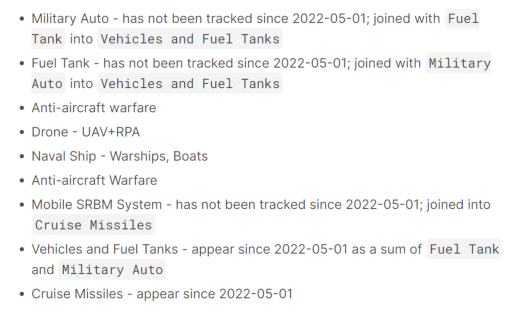

In [23]:
df_equipment.drop(columns=['day', 'greatest losses direction'], inplace=True)

img = mpimg.imread('./data/equipment_columns.PNG')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


- Por tanto, puedo unir a varias de un modo u otro para simplificar la tabla y reducir los nulos
- Primero tengo que convertir los nulos a ceros para poder hacer la sumas correspondientes. Hay valores de las columnas resultantes que tienen que quedar como cero, al ser cero todos los valores sumados
- La columna "special equipment" la elimino a pesar de que hay pocos nulos y podría suplirlos, ya que su contenido no está claro, siquiera, para el creador del dataset, así que difícilmente puedo sacar alguna conclusión al respecto. Además, si al final se trata de algo fácil de capturar o dañar, como munición o armas ligeras, puede desvirtuarme la tabla: https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war/discussion/316981



In [24]:
for column in df_equipment:
    df_equipment[column].fillna(0.0, inplace=True)

df_equipment['vehicles and fuel tanks'] = df_equipment['vehicles and fuel tanks'] + df_equipment['fuel tank'] + df_equipment['military auto']
df_equipment['missile systems'] = df_equipment['mobile SRBM system'] + df_equipment['cruise missiles']

df_equipment.drop(columns=['special equipment', 'cruise missiles', 'mobile SRBM system', 'fuel tank', 'military auto'], inplace=True)


- Desacumulo las columnas (decumulate_columns) y llevo la fecha al índice (index_by_datetime)
- Añado una columna con la suma de los equipamientos
- Elimino la primera fecha porque, al haber salido de un acumulado, coge cosas de fechas que no constan en la tabla

In [25]:
decumulate_columns(df_equipment, excluded=['date'])
index_by_datetime(df_equipment)

df_equipment['total losses'] = df_equipment.sum(axis=1)

df_equipment.drop(index='2022-02-25', inplace=True)


- Resultado:

In [26]:
df_equipment.head()


,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,vehicles and fuel tanks,missile systems,total losses
date,,,,,,,,,,,,
2022-02-26,17,19,66,190,0,0,2,0,0,30.0,0.0,324.0
2022-02-27,0,0,4,0,1,0,0,0,0,0.0,0.0,5.0
2022-02-28,2,3,0,110,24,17,1,0,5,161.0,0.0,323.0
2022-03-01,0,0,48,30,3,3,0,0,2,14.0,0.0,100.0
2022-03-02,1,2,13,16,8,16,0,0,2,50.0,0.0,108.0


### df_tech (pérdidas materiales rusas, incluyendo modelo y fabricante, sin fecha)

- Importo el dataframe y veo que hay nulos en cantidades industriales

In [27]:
df_tech = pd.read_csv(r'.\data\Russia_losses_equipment(tech_details).csv')

df_tech.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   equipment                                    298 non-null    object 
 1   model                                        298 non-null    object 
 2   sub_model                                    8 non-null      object 
 3   manufacturer                                 298 non-null    object 
 4   losses_total                                 298 non-null    int64  
 5   abandoned                                    77 non-null     float64
 6   abandoned and destroyed                      17 non-null     float64
 7   captured                                     196 non-null    float64
 8   captured and destroyed                       7 non-null      float64
 9   captured and stripped                        4 non-null      float64
 10  da

Compruebo cuántos nulos hay en total

In [28]:
df_tech.isnull().sum().sum()


3740

- Son muchos. Ahora bien, ¿cuántos de esos nulos son, en realidad, ceros (porque ha habido 0 bajas de ese tipo para tal pieza de equipamiento)? La manera de saberlo es fijarse en la columna "losses_total"; el total de bajas para cada pieza debería ser una suma de las destruidas y las capturadas. Si se queda corta, es que faltan datos
- Empiezo por cambiar los NaN por 0 (salvo para la columna sub_model, que no es numérica)
- Sumo los capturados y los pongo en una nueva columna, y hago lo propio con el resto de bajas

In [29]:
for column in df_tech:
    if column != 'sub_model':
        df_tech[column].fillna(0.0, inplace=True)

df_tech['total captured'] = df_tech[['captured', 
                                    'captured and destroyed',
                                    'captured and stripped',
                                    'damaged and captured'
                                    ]].sum(axis=1)

df_tech['total not captured'] = df_tech[['abandoned', 
                                        'abandoned and destroyed',
                                        'damaged',
                                        'damaged and abandoned',
                                        'damaged beyond economical repair',
                                        'damaged by Bayraktar TB2',
                                        'destroyed',
                                        'destroyed by Bayraktar TB2',
                                        'destroyed by Bayraktar TB2 and Harpoon AShM',
                                        'sunk'
                                        ]].sum(axis=1)


- Hago la comprobación. Parece que el total de pérdidas coincide con la suma de las partes para cada pieza de equipo. Por ende, no faltan datos a pesar de que hay multitud de nulos
- En paralelo reviso los no nulos de la columna sub_model


In [30]:
print(all(df_tech['losses_total']) == all(df_tech['total captured'] + df_tech['total not captured']))

df_tech[df_tech['sub_model'].notnull()]


True


,equipment,model,sub_model,manufacturer,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,...,damaged and abandoned,damaged and captured,damaged beyond economical repair,damaged by Bayraktar TB2,destroyed,destroyed by Bayraktar TB2,destroyed by Bayraktar TB2 and Harpoon AShM,sunk,total captured,total not captured
46,Infantry Fighting Vehicles,BMD-2,with RP-337VM1 jammer,the Soviet Union,2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
47,Infantry Fighting Vehicles,BMD-2,with RP-377VM1 jammer,the Soviet Union,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49,Infantry Fighting Vehicles,BMD-4M,with RP-337VM1 jammer,Russia,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
66,Infantry Mobility Vehicles,GAZ Tigr-M,with Arbalet-DM turret,Russia,7,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,6.0
77,Command Posts And Communications Stations,R-149MA3 command and staff vehicle,with RP-337VM1 jammer,Russia,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
100,Engineering Vehicles And Equipment,RKhM-6 Povozka,with RP-377VM1 jammer,Russia,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
269,"Trucks, Vehicles and Jeeps",Ural-4320,with ZU-23 AA gun,Russia,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
280,"Trucks, Vehicles and Jeeps",KamAZ 6x6,with ZU-23 AA gun,Russia,5,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0


- Los no nulos de la columna sub_model son modificaciones de los modelos originales. Como solo hay unos pocos con esas características de más, simplemente fusiono las dos columnas. Para el estudio, ya me va bien considerar cada combinación de modelo con submodelo (si lo hay) como un modelo propio

In [31]:
df_tech['sub_model'].fillna("", inplace=True)

df_tech['model'] = df_tech['model'] + ' ' + df_tech['sub_model']

df_tech.drop(columns='sub_model', inplace=True)


- Resultado:

In [32]:
df_tech.head()


,equipment,model,manufacturer,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,damaged by Bayraktar TB2,destroyed,destroyed by Bayraktar TB2,destroyed by Bayraktar TB2 and Harpoon AShM,sunk,total captured,total not captured
0,Tanks,T-62M,the Soviet Union,20,1.0,0.0,14.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,16.0,4.0
1,Tanks,T-62MV,the Soviet Union,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0
2,Tanks,T-64A,the Soviet Union,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
3,Tanks,T-64BV,the Soviet Union,39,2.0,0.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,5.0,34.0
4,Tanks,T-72A,the Soviet Union,33,1.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,15.0,18.0


### df_uk_tech (pérdidas materiales ucranianas, incluyendo modelo y fabricante, sin fecha)

- Este dataframe es idéntico al anterior, pero con pérdidas ucranianas. Por tanto, el tratamiento es el mismo

In [33]:
df_uk_tech = pd.read_csv(r'.\data\Ukraine_losses_equipment(tech_details).csv')

for column in df_uk_tech:
    if column != 'sub_model':
        df_uk_tech[column].fillna(0.0, inplace=True)

df_uk_tech['total captured'] = df_uk_tech[['captured', 
                                            'captured and destroyed',
                                            'damaged and captured',
                                            'damaged by Orion and captured',
                                            'sunk but raised by Russia'
                                            ]].sum(axis=1)

df_uk_tech['total not captured'] = df_uk_tech[['abandoned', 
                                                'abandoned and destroyed',
                                                'damaged',
                                                'damaged and abandoned',
                                                'damaged beyond economical repair',
                                                'damaged by Forpost-R',
                                                'destroyed',
                                                'destroyed by Forpost-R',
                                                'destroyed by Orion',
                                                'destroyed by loitering munition',
                                                'scuttled to prevent capture by Russia',
                                                'sunk'
                                                ]].sum(axis=1)

df_uk_tech['sub_model'].fillna("", inplace=True)

df_uk_tech['model'] = df_uk_tech['model'] + ' ' + df_uk_tech['sub_model']

df_uk_tech.drop(columns='sub_model', inplace=True)


Por si las moscas, hago la comprobación

In [34]:
all(df_uk_tech['losses_total']) == all(df_uk_tech['total captured'] + df_uk_tech['total not captured'])


True

- Resultado:

In [35]:
df_uk_tech.head()


,equipment,model,manufacturer,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,...,damaged by Orion and captured,destroyed,destroyed by Forpost-R,destroyed by Orion,destroyed by loitering munition,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia,total captured,total not captured
0,Tanks,T-64A,the Soviet Union,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Tanks,T-64B,the Soviet Union,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Tanks,T-64BV,the Soviet Union,123,3.0,0.0,41.0,8.0,3.0,1.0,...,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,70.0
3,Tanks,T-64BV Zr. 2017,Ukraine,49,3.0,0.0,27.0,0.0,1.0,1.0,...,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,22.0
4,Tanks,T-64B1M,Ukraine,4,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


## HIPÓTESIS

### Hipótesis 1

Se espera que los precios en Ucrania oscilen en función del número de refugiados que huyen del país (a más refugiados, menos demanda) y de la cercanía al frente de los puestos de venta (cuanto más cerca, más caro es transportar los productos). Asimismo, un peor rendimiento por parte del bando ruso debe de animar a los proveedores extranjeros a vender en el país y aumentar la oferta (con lo cual los productos son más baratos)

(Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos)

Esta hipótesis es un poco larga, así que la divido en tres partes (A, B y C)

#### Hipótesis 1: parte A

(Mayor lejanía del frente = precios más bajos)

- Miro el dataframe "df_prices"

In [36]:
df_prices.head()


,market,longitude,commodity,usdprice
date,,,,
2022-03-15,Rivne,26.251617,Antibiotics (imported),4.8148
2022-03-15,Rivne,26.251617,Antibiotics (local),1.0399
2022-03-15,Rivne,26.251617,Antipyretic (local),0.4625
2022-03-15,Rivne,26.251617,Vasodilating agents (local),0.3667
2022-03-15,Rivne,26.251617,Vasodilating agents (imported),1.5907


- Creo una función ad hoc (create_lmplot_w_regression_line) que me dibuja un gráfico de tipo lmplot pero que, dado que necesito hacer más de uno, que lo haga con algunos valores por defecto. Así me ahorro escribir lo mismo dos veces. No me la llevo a utils porque solo sirve para este caso y no quiero guardarla para futuros análisis

In [37]:
'''Creates a seaborn lmplot (with regression lines) using a few default values'''
def create_lmplot_w_regression_line(data, x="longitude", y="usdprice", hue=None, xlabel=None, ylabel=None, title=None, legend=True, scatter=25, line=2, ci=95):
    '''Requires a dataframe (positional argument) and two column names (key arguments; "longitude" and "usdprice" by default). Other parameters are optional and named after the ones used in a seaborn lmplot'''
    sns.lmplot(data=data, x=x, y=y, hue=hue, legend=legend, scatter_kws={"s": scatter}, line_kws={'linewidth':line}, ci=ci)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    plt.title(title)
    plt.tight_layout()


- Separo el dataframe entre medicamentos locales o importados
- Activo la función anterior para los dos casos

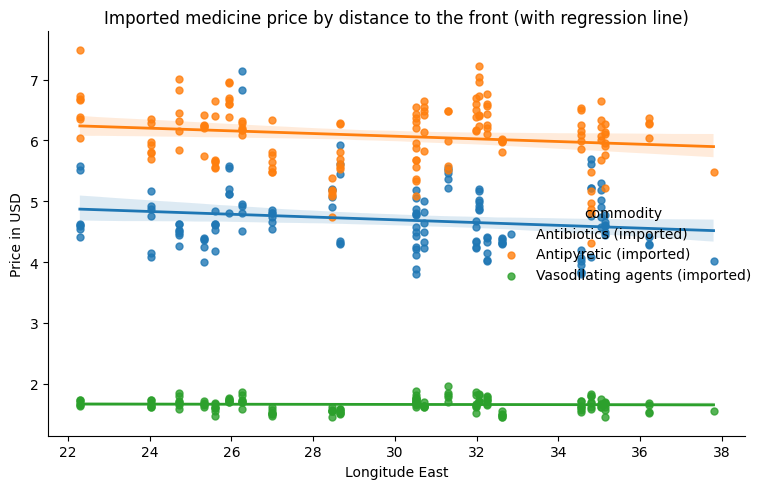

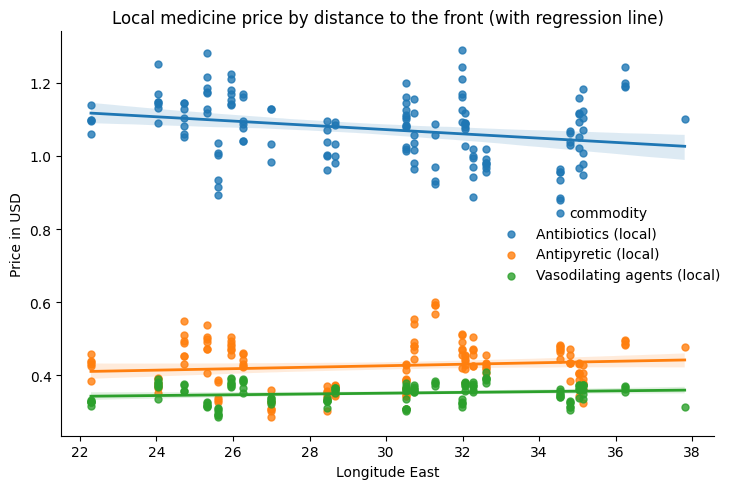

In [38]:
df_prices_imported = df_prices[df_prices['commodity'].str.contains('imported')]
df_prices_local = df_prices[df_prices['commodity'].str.contains('local')]

plt.rc("figure", figsize=(6.4,4.8))
create_lmplot_w_regression_line(df_prices_imported.sort_values(by='commodity'), ylabel='Price in USD', hue="commodity", xlabel='Longitude East', title='Imported medicine price by distance to the front (with regression line)')
plt.show()
create_lmplot_w_regression_line(df_prices_local.sort_values(by='commodity'), ylabel='Price in USD', hue="commodity", xlabel='Longitude East', title='Local medicine price by distance to the front (with regression line)')
plt.show()


- Se nota que los precios de los importados son muy superiores (exceptuando los vasodilatadores). Para los dos casos, además, los precios de los antibióticos y los antipiréticos parecen oscilar más
- Algunas de las líneas de regresión bajan un poco al ir acercándose al frente, pero es un cambio demasiado pequeño como para considerarse significativo. Así las cosas, una mayor distancia al frente no reduce necesariamente el precio de las medicinas. ¿Ocurre lo mismo con los demás productos?

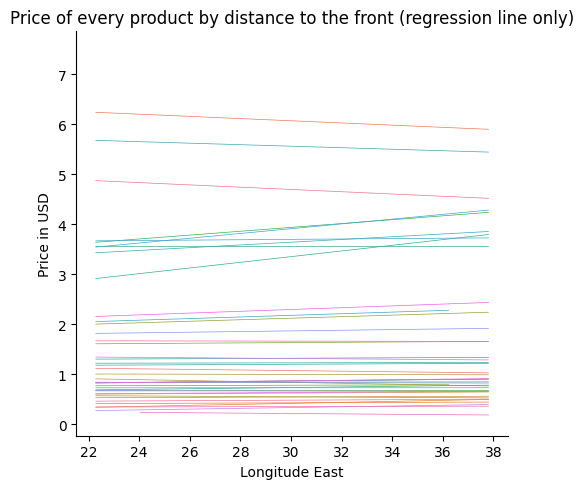

In [39]:
df_prices_2 = pd.read_csv(r'.\data\Prices.csv', low_memory=False)

df_prices_2.drop(index=0, inplace=True)

df_prices_2[['usdprice', 'longitude', 'price']] = df_prices_2[['usdprice', 'longitude', 'price']].apply(pd.to_numeric, errors='coerce', axis=1)

df_prices_2.loc[df_prices_2['commodity'] == 'Antipyretic (imported)', 'usdprice'] = df_prices_2[df_prices_2['commodity'] == 'Antipyretic (imported)']['usdprice'] * 10

df_prices_3 = df_prices_2.copy()

index_by_datetime(df_prices_2)

df_prices_2 = df_prices_2[df_prices_2.index >= start_war]

create_lmplot_w_regression_line(df_prices_2.sort_values(by='commodity'), ylabel='Price in USD', hue="commodity", xlabel='Longitude East', title='Price of every product by distance to the front (regression line only)', legend=False, scatter=0, line=0.5, ci=0)
plt.show()


- Lo confirmo con la misma gráfica lmplot que antes, pero aplicada al conjunto de productos (elimino los puntos y la leyenda para que se vea más claro, además de reducir el tamaño de las líneas); casi todas las líneas de regresión son prácticamente paralelas (si bien hay dos o tres excepciones poco significativas)
- Con lo visto, intuyo que un análisis pormenorizado de los medicamentos me puede ofrecer resultados más interesantes que uno generalista, que intente abarcar el conjunto de productos. Por esa razón, para el resto de la hipótesis 1 me centro en los antibióticos, los vasodilatadores y los antipiréticos
- Como ya no necesito la longitud, puedo comprobar la oscilación de los precios de los medicamentos con la desviación estándar

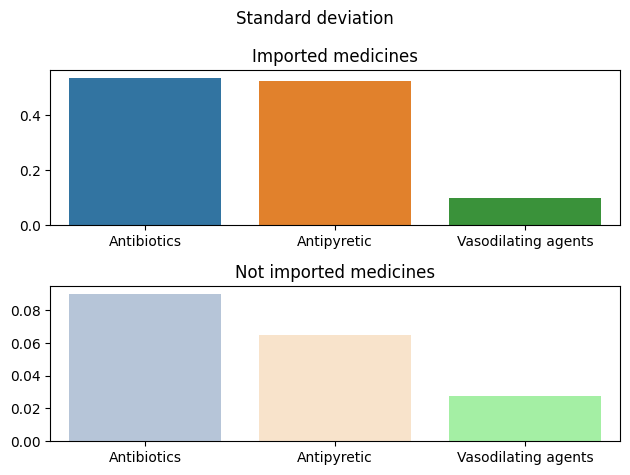

In [40]:
df_imp_antibiotics, df_imp_antipyretic, df_imp_vasodilating = [table for med, table in df_prices_imported.groupby('commodity')]
df_loc_antibiotics, df_loc_antipyretic, df_loc_vasodilating = [table for med, table in df_prices_local.groupby('commodity')]

plt.subplot(2, 1, 1)
sns.barplot(x=['Antibiotics', 'Antipyretic', 'Vasodilating agents'], y=[df_imp_antibiotics['usdprice'].std(), df_imp_antipyretic['usdprice'].std(), df_imp_vasodilating['usdprice'].std()])
plt.title('Imported medicines')
plt.subplot(2, 1, 2)
sns.barplot(x=['Antibiotics', 'Antipyretic', 'Vasodilating agents'], y=[df_loc_antibiotics['usdprice'].std(), df_loc_antipyretic['usdprice'].std(), df_loc_vasodilating['usdprice'].std()], 
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
            )
plt.title('Not imported medicines')
plt.suptitle('Standard deviation')
plt.tight_layout()
plt.show()


- La desviación típica es mayor en el caso de los antibióticos y los antipiréticos, tanto para los locales como para los importados
- Es posible que haya una demanda muy superior para los antibióticos y los antipiréticos, la cual hace que los precios sean más altos en general y que oscilen. ¿Tiene que ver con la guerra? Lo compruebo con facilidad, ya que el dataframe original de precios abarca varios años


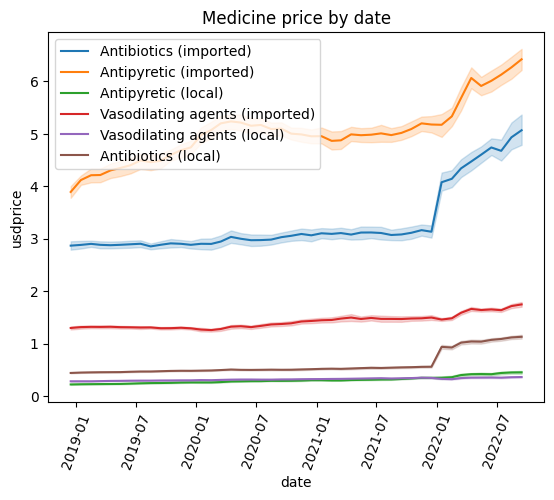

In [41]:
df_prices_3 = df_prices_3[df_prices_3['commodity'].str.contains('imported') | df_prices_3['commodity'].str.contains('local')]

df_prices_3['date'] = pd.to_datetime(df_prices_3['date'], exact=False)

sns.lineplot(data=df_prices_3, x='date', y='usdprice', hue='commodity')
plt.tick_params(axis='x', labelrotation = 70)
plt.title('Medicine price by date')
plt.legend(loc='upper left')
plt.show()


- Efectivamente, con la guerra hay una subida de estos medicamentos. Es llamativo que los antipiréticos locales sean tan baratos; es posible que se trate de un error humano al hacer la tabla, y  que la unidad de medida de los locales sea, como para los importados, "1 sachet", y no "10 tablets"
- En cuanto al total de medicamentos, ¿qué tan grave es esa oscilación de precios para los usuarios? Para descubrirlo, creo una función que calcula el índice de Gini (calculate_gini). Normalmente se usa para comprobar si un reparto es equitativo; aquí me sirvo de él para ver si los costes de los medicamentos se reparten de forma justa entre los diferentes mercados. Necesito, para ello, la media (o la mediana) de precios de cada mercado

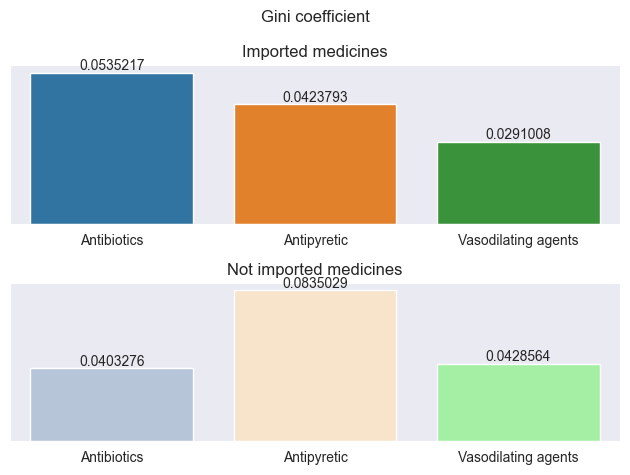

In [42]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(2)
    sns.barplot(x=['Antibiotics','Antipyretic', 'Vasodilating agents'], y=[calculate_gini(df_imp_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[0]
                )
    ax[0].set_title('Imported medicines')

    sns.barplot(x=['Antibiotics','Antipyretic', 'Vasodilating agents'], y=[calculate_gini(df_loc_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[1],
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
                )

    for number in range (0,2):
        for i in ax[number].containers:
            ax[number].set_yticks([])
            ax[number].bar_label(i,)

    ax[1].set_title('Not imported medicines')
    fig.suptitle('Gini coefficient')

    fig.tight_layout()
    plt.show()


- El resultado es tan concluyente (muy alejado de 1) que da igual, para el caso, investigar si es mejor servirse de la media o la mediana, así que lo dejo con la media
- El índice de Gini está cerca de 0 para todos los medicamentos, lo cual indica que un usuario de a pie no percibe fácilmente de que el precio varía de ciudad a ciudad

#### Hipótesis 1: parte B

(Más pérdidas rusas = precios más bajos)

- Quiero comprobar si los precios oscilan con las bajas rusas personales y materiales. La cuestión es que los precios los tengo calculados mensualmente, mientras que las bajas, día a día. Quiero saber, para cada mes que aparece en el índice de los precios (df_prices), cuantas bajas ha habido durante el mes previo en las tablas de bajas
- Por ejemplo, si en la tabla de precios tengo el mes 2022-05-15, quiero sumar las bajas desde 2022-05-14 hasta 2022-04-15... y así para cada mes de la tabla de precios (excepto el primero, ya que se trata de 2022-03-15, y no hay cuenta de bajas antes del 2022-02-25)
- Para ello, creo una función (date_index_to_monthly)

In [43]:
datetimes_to_study = df_prices.index.drop_duplicates()
df_monthly_personnel_datetime, df_monthly_personnel = date_index_to_monthly(df_personnel, 'personnel', 'Personnel losses', datetimes_to_study[1:])
df_monthly_equipment_datetime, df_monthly_equipment =  date_index_to_monthly(df_equipment, 'total losses', 'Equipment losses', datetimes_to_study[1:])

df_monthly_equipment


,Equipment losses
4,2494.0
5,2692.0
6,1648.0
7,1098.0
8,1146.0
9,1912.0


- Con esto ya puedo crear un gráfico de las bajas mes a mes. Ahora bien, si quiero hacerme una idea general, necesito, también, gráficos de precios por mes para cada uno de los tipos de medicamentos (6 en total, contando importados y locales). Como debo calcular una cifra para cada mes que aglutine todas las ciudades, me toca decidir de nuevo entre la media y la mediana. Esta vez sí que hay que tenerlo en cuenta, ya que no busco un coeficiente para el cual prevea un resultado decisivo, sino llevar a cabo una comparativa visual
- Como quiero ver la tendencia con claridad (y que no quede emborronada por algún outlier) y no me preocupan tanto los valores concretos, me sirvo de la mediana
- Elimino la columna "longitude" de df_prices, que ya no la necesito
- Itero por cada posible medicamento (soy consciente de que puedo usar una función para obtener por los nombres de los medicamentos, pero prefiero crear una lista a mano, commodities, que me permita sacar los subplots en el orden que yo quiero, por una cuestión estética. De este modo, los medicamentos locales e importados me salen en la misma fila en la gráfica, y en la misma columna en función del tipo), saco la mediana de todas ciudades para cada fecha, borro el índice inicial (que no aparece en la tabla de bajas por razones ya expuestas), y, así, voy creando cada gráfica. Utilizo una función (apply_condition_groupby_mean_drop) para buena parte del proceso porque intuyo que me toca hacerlo de nuevo más adelante

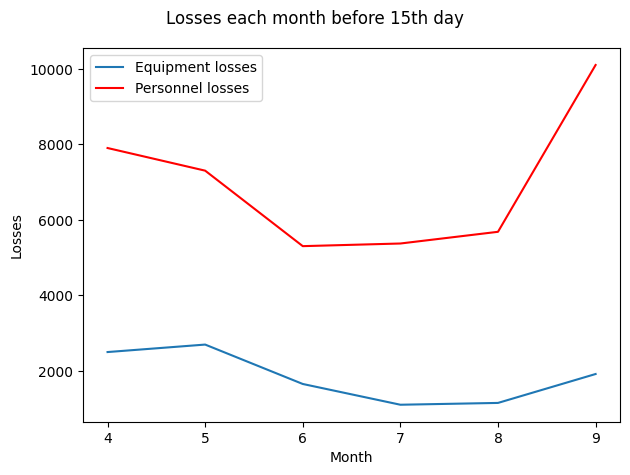

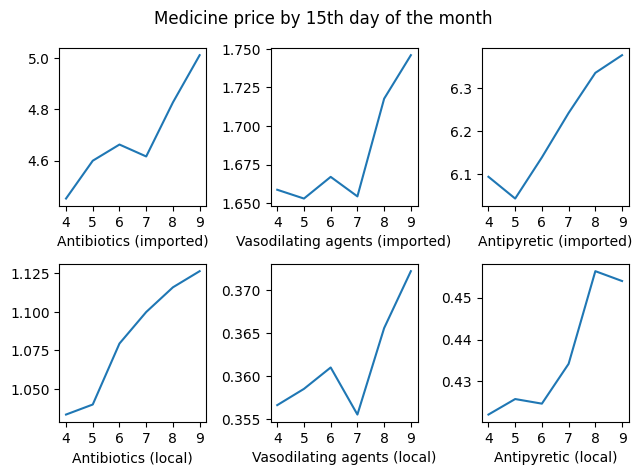

In [44]:
sns.lineplot(df_monthly_equipment)
sns.lineplot(df_monthly_personnel, palette=['r'])
plt.ylabel(ylabel="Losses")
plt.xlabel(xlabel="Month")
plt.suptitle('Losses each month before 15th day')
plt.tight_layout()
plt.show()

df_prices.drop(columns='longitude', inplace=True)

commodities = ['Antibiotics (imported)', 'Vasodilating agents (imported)', 'Antipyretic (imported)', 'Antibiotics (local)',  'Vasodilating agents (local)', 'Antipyretic (local)']
count = 0
for element in commodities:
    df_prices_monthly_single_med = apply_condition_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=['2022-03-15'], median=True)
    df_prices_monthly_single_med.index = ['4', '5', '6', '7', '8', '9']
    count +=1
    plt.subplot(2, 3, count)
    sns.lineplot(df_prices_monthly_single_med)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=element)
plt.suptitle('Medicine price by 15th day of the month')
plt.tight_layout()
plt.show()


- Como veo que alrededor del mes 6 se producen cambios importantes en todas las gráficas, calculo la correlación total, así como la de antes y a partir de ese punto
- Antes de hacerlo, sin embargo, tengo que elegir entre las bajas de personal y las materiales. Ambas siguen una tendencia similar, pero la de personal parece más pronunciada. Creo que puede dar resultados más claros en caso de hacer una correlación. Lo compruebo con el coeficiente de asimetría de Fisher

In [45]:
print(df_monthly_equipment.skew(), '\n', df_monthly_personnel.skew())


Equipment losses    0.206234
dtype: float64 
 Personnel losses    0.989514
dtype: float64


- El coeficiente de asimetría de las bajas de personal está mucho más cerca de 1 porque, si bien en ambos casos hay una asimetría por la derecha (se "hunden" por la derecha), en su caso el desequilibrio es mayor. Ello confirma la corazonada que he tenido al ver la gráfica. Así pues, decido usar las bajas de personal para el cálculo de la correlación
- Creo una lista de listas con los índices que tengo que eliminar para calcular las 3 diferentes correlaciones (recordemos: total, antes del mes 6 y después del mes 6)
- Con la misma función de antes, creo subconjuntos para cada medicamento con la mediana de los precios de las ciudades para cada fecha, pero, esta vez, voy liquidando los índices que no me interesan para cada caso mediante el argumento index_drops
- Cada subconjunto lo fusiono con el dataframe de personal que he creado antes con la función date_index_to_monthly. Es lo mismo que el df_monthly_personnel que he usado para el lineplot de bajas, pero con fechas en el índice (es necesario que sea así para que el merge por el índice funcione)
- Meto en una lista cada vector con los números correspondientes a los meses que me interesan, y, luego, todas las listas en una lista más grande
- Con esa lista de listas ya puedo crear el gráfico de correlación

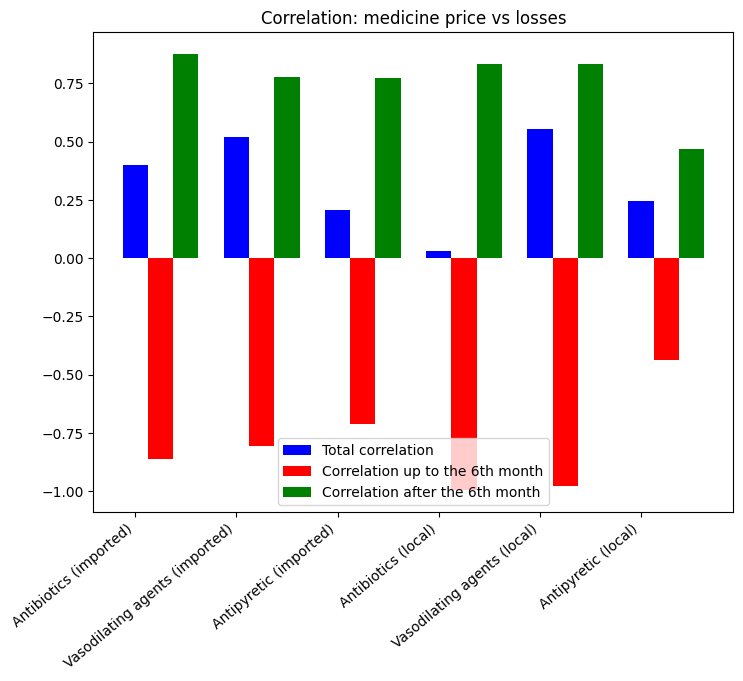

In [46]:
total_index_drops = [['2022-03-15'], ['2022-03-15', '2022-07-15', '2022-08-15', '2022-09-15'], ['2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15']]

corr_vectors = []
for index_drops in total_index_drops:
       corr_vector = []
       for element in commodities:
              df_prices_monthly_single_med = apply_condition_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=index_drops, median=True)
              df_price_personnel = df_prices_monthly_single_med.merge(df_monthly_personnel_datetime, left_index=True, right_index=True)
              corr_vector.append(df_price_personnel.corr()['usdprice'][1])
       corr_vectors.append(corr_vector)

X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, corr_vectors[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, corr_vectors[1], color = 'r', width = 0.25)
ax.bar(X + 0.50, corr_vectors[2], color = 'g', width = 0.25)
plt.xticks([0, 1, 2, 3, 4, 5], commodities)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(labels=['Total correlation', 'Correlation up to the 6th month', 'Correlation after the 6th month'])
plt.title('Correlation: medicine price vs losses')
plt.show()


- Veo que la correlación cambia totalmente de sentido en ambos casos (antes del mes 6 y después del mes 6), y lo hace de manera contundente (para los 6 medicamentos)
- En términos generales, las bajas y los medicamentos están correlacionados, aunque de un modo poco tajante
- Antes del mes 6, van en la dirección contraria. Sin embargo, a partir del mes 6, van en la misma, y se vuelve muy palpable
- Los medicamentos suben siempre, y las bajas primero bajan y luego suben. Lo que ourre, con toda probabilidad, es que los medicamentos siempre suben, y las pérdidas primero bajan y luego suben, de ahí que estén correlacionadas
- Aunque no sea correcto decir que los precios de los medicamentos vienen dados por las pérdidas de personal, sí puedo asegurar que en el mes 6 las bajas sufren un giro
- La hipótesis 2 estudia las bajas de personal comparadas con las de equipamiento. Me interesa ver qué ocurre en el mes 6 para que se produzca tal cambio

#### Hipótesis 1: parte C

(Más refugiados = precios más bajos)

- Solo queda comprobar si los refugiados siguen una tendencia similar a lo que ya hemos visto; es decir, si pasa algo con ellos en el mes 6
- Echo un vistazo a la tabla

In [47]:
df_refugees['country'].value_counts()


Hungary                     106
Slovakia                    105
Poland                      102
Republic of Moldova         102
Romania                      93
Belarus                      76
Russian Federation           70
Other European countries     11
Name: country, dtype: int64

- La situación es complicada. Quiero saber los refugiados que hay totales los días 15 de cada mes (los del índice de la tabla mensual de precios, pero sin contar el último, ya que la tabla de refugiados acaba el 2022-09-13). Sin embargo, puedo intuir que hay países para los que no se hacen las cuentas todos los meses... y mucho menos el día 15 en concreto
- Necesito una función que, por cada día 15 de esos, me mire para qué países hay datos y los sume (recordemos que el dataframe de refugiados es un acumulado). Si no encuentra datos para algún país, que mire en la fecha más cercana (el día 16, si acaso existe en el dataframe) para obtener una aproximación. Si sigue sin encontrar nada, que mire en la fecha siguiente... y así sucesivamente hasta haber sumado los datos de todos los países para (más o menos) ese día 15. Luego, la función debe hacer lo mismo para el resto de días 15 de cada mes. Al final, debe devolver un dataframe con el total de refugiados por fecha
- Soy consciente de que lo que obtengo de esto es una aproximación, dado que no todos los valores sumados salen realmente del 15 de cada mes. Sin embargo, como la fuente es un acumulado con valores bastante grandes, si procuro que no se alejen demasiado de la fecha que les corresponde (no más de 15 días), el resultado es útil al menos para detectar una tendencia general
- Tengo la función, se llama sum_by_duplicated_values_and_datetime. Con cada uso, la función imprime el proceso que va haciendo. Con este método, puedo ir calibrando si, para algún país, se aleja demasiado del día 15 a la hora de hacer su aproximación, y valorar si tengo que eliminarlo de la tabla
- Tras varios usos, estos son los países que me veo obligado a desechar: solo uno, "Other European countries", que ya se aleja lo indecible de la primera fecha 15 en la primera vuelta, pues no es capaz de rellenar ni un mes (todos sus valores deben ser anteriores al 2022-03-15). Ninguno más, ya que los datos para el resto de países se encuentran antes de llegar al 30 del propio mes, con lo que considero que son una aproximación válida

In [48]:
condition = df_refugees[(df_refugees['country'] == 'Other European countries')].index
df_refugees.drop(condition, inplace=True)

df_monthly_refugees = sum_by_duplicated_values_and_datetime(df_refugees, 'country', 'individuals', datetimes_to_study[:-1])


Now checking for 2022-03-15 00:00:00
2022-03-15 00:00:00 has been filled


Now checking for 2022-04-15 00:00:00
Missing: ['Belarus', 'Russian Federation']
Add 1 day/s. Current date: 2022-04-16 00:00:00
Missing: ['Belarus', 'Russian Federation']
Add 1 day/s. Current date: 2022-04-17 00:00:00
Missing: ['Belarus', 'Russian Federation']
Belarus found at 2022-04-17 00:00:00
Russian Federation found at 2022-04-17 00:00:00
2022-04-15 00:00:00 has been filled


Now checking for 2022-05-15 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-16 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-17 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-18 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-19 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-20 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-21 00:00:00
2022-05-21 00:00:00 does not exist in the dataframe
Add 1 day/s. Current date: 2022-05-22 00:00:0

- Desacumulo df_refugees (decumulate_columns), me llevo la fecha al índice (index_by_datetime), borro el primer mes (ya que no hay con qué desacumularlo), modifico el índice para mostrar solo los meses y tengo la tabla resultante

In [49]:
decumulate_columns(df_monthly_refugees, excluded='date')
index_by_datetime(df_monthly_refugees, name='date')

df_monthly_refugees.drop(index='2022-03-15', inplace=True) 
df_monthly_refugees.index = ['4', '5', '6' , '7', '8']

df_monthly_refugees


,Total
4,1811671
5,1338294
6,1490797
7,1844112
8,1652311


- A partir de ahí hago la gráfica. Detecto que, efectivamente, entre el mes 6 y el 7 los refugiados se disparan

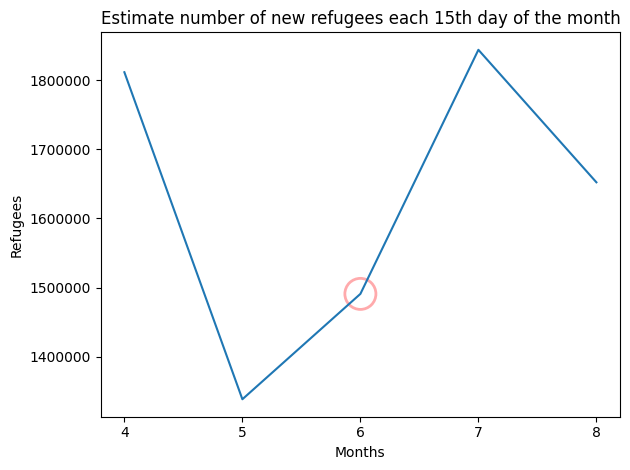

In [50]:
fig, ax = plt.subplots()
ax.scatter(2, 1490797, s=500, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_monthly_refugees['Total'], x=df_monthly_refugees.index)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Refugees')
plt.xlabel(xlabel='Months')
plt.title('Estimate number of new refugees each 15th day of the month')
plt.tight_layout()
plt.show()


#### Hipótesis 1: conclusiones

Parte A
- No hay relación palpable entre la cercanía al frente y el precio de los productos. La guerra moderna, con artillería de larga distancia y bombardeos aéreos, y con un frente largo y difícil de localizar, implica que todas las ciudades sean susceptibles de sufrir problemas puntuales de suministro independientemente de su proximidad al enemigo
- Los precios de los antibióticos y los antipiréticos, además de ser superiores en términos generales, oscilan mucho. Como el país se encuentra en situación de guerra, es de prever que la demanda de este tipo de medicamentos, muy útiles para una persona herida o con fiebre, se haya disparado. De ahí que oscilen de un modo dramático comparados con los agentes vasodilatadores, que sirven para tratar la tensión arterial, un problema de salud cuyos factores de riesgo no se ven agravados en un conflicto bélico
- Para muestra, Mayo Clinic ofrece un listado de factores de riesgo para una tensión arterial alta (https://www.mayoclinic.org/es-es/diseases-conditions/high-blood-pressure/symptoms-causes/syc-20373410). Cuestiones como la edad, la raza, el sobrepeso o el consumo de tabaco no cambian tanto en un conflicto bélico como la posibilidad de sufrir fiebre o infecciones a causa de heridas, falta de refugio, de alimentos, etc.
- Es poco probable que las diferencias en el precio de los medicamentos de ciudad a ciudad, por sí solas, supongan un problema para los consumidores, ya que el índice de Gini es bajo para todas; el único problema es que la demanda suba tanto que estos lleguen a escasear (o que la oferta se reduzca)

Parte B
- No existe una relación palpable entre el precio de la medicina y las pérdidas rusas. En términos de correlación, el precio de la medicina sube, mientras que las pérdidas primero bajan y luego suben
- Es a partir del mes 6 que las bajas rusas vuelven a subir

Parte C
- Los refugiados mensuales se disparan entre el mes 6 y el 7, momento en que hemos visto que las bajas rusas llegan a su punto más bajo (es probable que la guerra se recrudezca en este punto)
- He desmentido de forma prematura la hipótesis 2 con el lineplot de bajas (las bajas personales y materiales rusas no siguen tendencias diametralmente opuestas). Sin embargo, sigo adelante con la investigación para encontrar pistas sobre lo que pasa alrededor del mes 6

### Hipótesis 2

(Uso mayor de tropas mecanizadas = uso reducido de soldados rasos = más pérdidas materiales y menos muertos)

- Aunque ya sé que la hipótesis no se cumple, investigar el dataset de equipamiento quizá me ayude a arrojar luz sobre lo que ocurre con el mes 6
- Empiezo con un boxplot, con el que veo que 1) hay diferencias importantes en los números de bajas; 2) los outliers de las bajas totales ("total losses"), con toda probabilidad, vienen principalmente de las bajas de APC - que, además, son mayoritarias- y de los "vehicles and fuel tanks"; y 3) no hay outliers en el límite inferior de las bajas totales, lo que significa que no debo preocuparme por números exageradamente bajos si, por alguna razón, acabo mirando por debajo de la mediana
- Percibo, también, un error relativo a las bajas de APC. Están por debajo de 0, y no puede haber bajas negativas

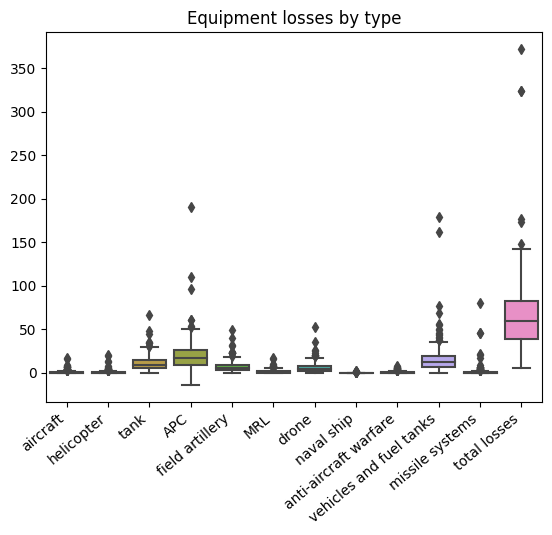

In [51]:
ax = sns.boxplot(df_equipment)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Equipment losses by type')
plt.show()


- Una vez localizado el error, pregunto al creador del dataset y parece que es una corrección de los datos acumulados: https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war/discussion/369515
- Decido ignorarlo porque es algo muy pequeño y puntual como para afectar a la visión conjunta

In [52]:
df_equipment[df_equipment.index == '2022-10-13']


,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,vehicles and fuel tanks,missile systems,total losses
date,,,,,,,,,,,,
2022-10-13,0,5,6,-14,49,2,53,1,1,8.0,1.0,112.0


- Con lo visto, parece que son las bajas de APC y las de "vehicles and fuel tanks" las mayoritarias
- Compruebo hasta qué punto es así con un gráfico

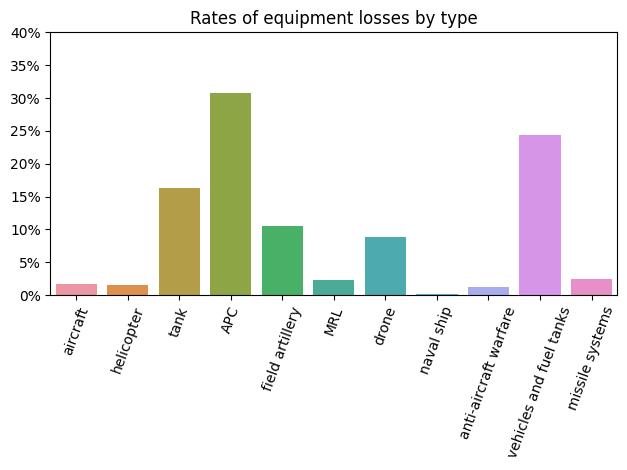

In [53]:
column_names = []
results = []
for column in df_equipment:
    if column != 'total losses':
        column_names.append(column)
        results.append(sum(df_equipment[column]) /  sum(df_equipment['total losses']) * 100)

sns.barplot(x=column_names, y=results)
plt.tick_params(axis='x', labelrotation = 70)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40], ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
plt.title('Rates of equipment losses by type')
plt.tight_layout()
plt.show()


- Cabe suponer, con lo que he visto en las hipótesis previas, que a partir del mes 6 hay una caída en las bajas: lo compruebo con dos gráficos, uno con las bajas de APC + "vehicles and fuel tanks" y las pérdidas totales, y otro con el resto de tipos de bajas y las pérdidas totales. Así, de paso, puede que vea alguna otra tendencia
- Noto que hay lo que parece ser una bajada que va del mes 6 al 9. Cuando vuelven a subir las bajas totales, las de APC y "vehicles and fuel tanks" ya no son tan fuertes 

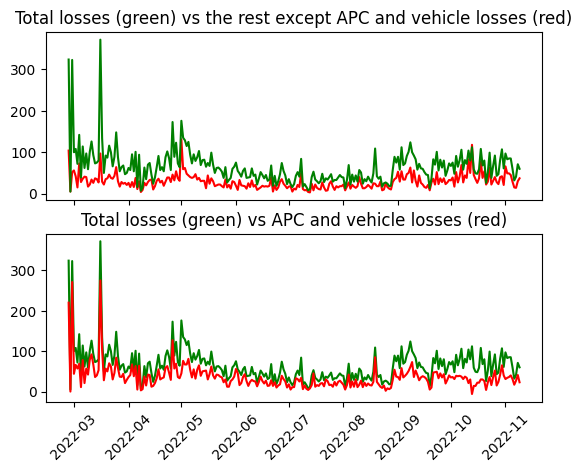

In [54]:
fig, ax = plt.subplots(2)
ax[0].plot(df_equipment.index, df_equipment.drop(columns=['APC','vehicles and fuel tanks', 'total losses']).sum(axis=1), 'r', df_equipment.index, df_equipment['total losses'], 'g')
ax[0].tick_params(labelbottom=False)
ax[0].title.set_text('Total losses (green) vs the rest except APC and vehicle losses (red)')
ax[1].plot(df_equipment.index, df_equipment['total losses'], 'g', df_equipment.index, df_equipment['APC'] + df_equipment['vehicles and fuel tanks'], 'r')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].title.set_text('Total losses (green) vs APC and vehicle losses (red)')
plt.show()


- Quiero demostrar, ahora, la caída entre el mes 6 y el 9, que se intuye por los gráficos pero no se percibe con total claridad
- Necesito la probabilidad de que un conjunto de bajas diarias situado entre el mes 6 (incluido, que es el estándar al calcular intervalos) y el 9 esté por debajo de la mediana
- ¿Por qué la mediana? Por dos razones: 1) He visto que hay outliers, de ahí que prefiera la mediana antes que la media, y 2) no hay outliers por debajo de la mediana, como demuestra el boxplot previo
- Según la fórmula de la probabilidad condicionada, tengo que dividir la probabilidad de que un conjunto de bajas diarias al azar esté entre el mes 6 y el 9 y por debajo de la mediana (interseccion), entre el porcentaje de fechas que se cuentan en este intervalo
- Cerca del 90% de las bajas diarias que se encuentran en este período están por debajo de la mediana. Esto demuestra matemáticamente que hay una bajada entre los meses 6 y 9

In [55]:
p_interseccion_mediana_periodo = (len(df_equipment[(df_equipment['total losses'] < df_equipment['total losses'].median())
                                    & (df_equipment.index >= '2022-06-01') 
                                    & (df_equipment.index < '2022-09-01')]
                                        ) / len(df_equipment['total losses'])
                                    )

p_periodo = len(df_equipment[(df_equipment.index >= '2022-06-01') & (df_equipment.index < '2022-09-01')]) / len(df_equipment.index)

p_periodo_mediana = p_interseccion_mediana_periodo / p_periodo * 100

p_periodo_mediana


89.13043478260869

#### Hipótesis 2: conclusiones

- La mayoría de bajas son de APC. Esas son las siglas de Armored Personnel Carrier, lo cual implica que hay bajas de personal simultáneamente, ya que se destruyen vehículos dedicados al transporte de personal, si bien con capacidades defensivas
- La columna "vehicles and fuel tanks", que también es mayoritaria, incluye, a todas luces, los vehículos sin capacidad de autodefensa de transporte de personal junto con los de transporte de combustible. Así pues, esta categoría y la de APC incluyen fundamentalmente vehículos de transporte de infantería
- La mayor parte de bajas diarias para el período de 6 a 9 meses están por debajo de la mediana
- Como hemos visto en el primer gráfico de "Hipótesis 1: parte B", las bajas de personal para este período (aproximadamente) también se encuentran en un punto bajo
- Se deduce, pues, que el hecho de que haya menos bajas de personal (y no solo de equipamiento) tiene que ver con que se han destruido menos APC y/o vehículos de transporte convencionales en este período, pues la destrucción de cualquiera de los dos tipos de vehículo supone, irremediablemente, la muerte de sus tripulantes y pasajeros
- Cabe recordar que, en el mes 6, también suben mucho los refugiados. Para este período, es probable que Rusia se esté apoyando más en bombardeos y artillería que en la conquista de territorio con tropas terrestres. Eso explicaría tanto el aumento de refugiados (se puede vivir en una ciudad ocupada, pero no devastada) como la menor pérdida de convoyes de transporte -y, por ende, de personal en general-. El hecho de que, cuando vuelven a subir las bajas de personal (visto en la hipótesis 1) y de equipamiento totales (visto en el gráfico previo), alrededor del mes 9, las bajas de vehículos de transporte ya no suban tanto, da fuerza a esta proposición

### Hipótesis 3

(Uso de material soviético = más destrucciones y más capturas)

- Empiezo con un mapa de calor de la correlación para tener una idea general

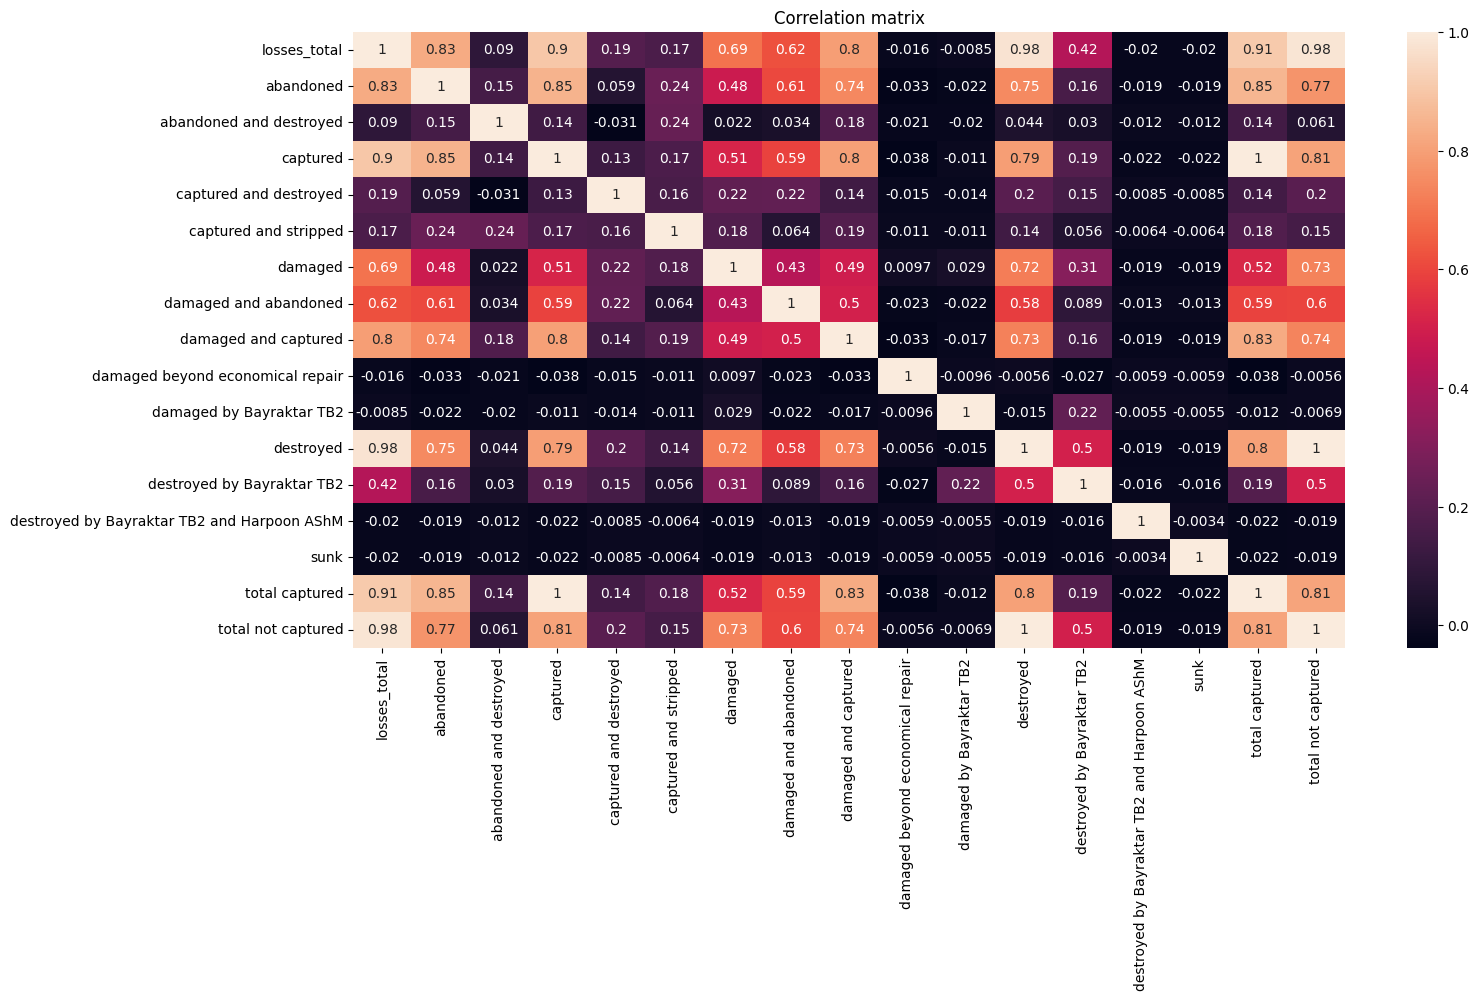

In [56]:
plt.rc("figure", figsize=(16,8))

corr = df_tech.loc[:, 'losses_total':].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


- Veo una correlación curiosa entre equipamiento abandonado (que cuenta como no capturado) y el equipamiento capturado total
- Quiero comprobar si sus medias son iguales para saber si vale la pena investigar esa correlación
- Elijo ttest porque, aunque hay más de 30 valores, según el Ftest las varianzas son diferentes
- Las medias también son diferentes... el valor de capturas totales es mayor


In [57]:
print(Ftest(df_tech['abandoned'], df_tech['total captured']))

_ , p = stats.ttest_ind(df_tech['abandoned'], df_tech['total captured'], alternative = 'two-sided', equal_var = False)
print(p)

_ , p = stats.ttest_ind(df_tech['abandoned'], df_tech['total captured'], alternative = 'greater', equal_var = False)
print(p)


1.6985973897790395e-180
2.434713095967071e-08
0.9999999878264345


- Hago la misma comprobación con "captured" y "total captured", así como con "destroyed" y "total not captured"
- Las varianzas son las mismas y hay más de 30; por tanto, toca ztest
- Las medias son iguales; si fuera necesario, sería razonable, pues, referirse al total de capturados y no capturados simplemente como "capturados" y "destruidos" respectivamente


In [58]:
print(Ftest(df_tech['captured'], df_tech['total captured']))
print(Ftest(df_tech['destroyed'], df_tech['total not captured']))

_ , p = sm.stats.ztest(df_tech['captured'], df_tech['total captured'], alternative = "two-sided")
print(p)
_ , p = sm.stats.ztest(df_tech['destroyed'], df_tech['total not captured'], alternative = "two-sided")
print(p)


0.21546163746052155
0.10708891618988328
0.7127442868124878
0.5885803729694092


- Es el momento de centrarse en la hipótesis. Creo dos tablas, una de equipamiento soviético y otra de no soviético

In [59]:
df_tech_soviet = df_tech[df_tech['manufacturer'] == 'the Soviet Union']

df_tech_not_soviet = df_tech[df_tech['manufacturer'] != 'the Soviet Union']

df_tech_not_soviet_totals = df_tech_not_soviet.groupby('equipment').sum(numeric_only=True)[['total captured', 'total not captured']]

df_tech_soviet_totals = df_tech_soviet.groupby('equipment').sum(numeric_only=True)[['total captured', 'total not captured']]

df_tech_soviet_totals


,total captured,total not captured
equipment,,
Aircraft,0.0,30.0
Anti-Aircraft Guns,11.0,3.0
Armoured Fighting Vehicles,200.0,254.0
Armoured Personnel Carriers,76.0,85.0
Artillery Support Vehicles And Equipment,27.0,27.0
Command Posts And Communications Stations,7.0,14.0
Engineering Vehicles And Equipment,66.0,65.0
Heavy Mortars,10.0,5.0
Helicopters,0.0,3.0


- Las represento gráficamente
- Los vehículos de transporte de infantería, tanto los que tienen capacidad ofensiva ("infantry fighting vehicles", llamados APC en la hipótesis anterior) como los inofensivos ("trucks, vehicles and jeeps") son mayoría para los conjuntos soviético y no soviético respectivamente
- Se ve una categoría de "APC" (Armoured Personnel Carrier) en estos gráficos, también, pero eso y "infantry fighting vehicles" (IFV) son prácticamente lo mismo, con pequeñas (y muy discutidas) diferencias (el uno estaría más orientado al transporte, y, el otro, al combate, respectivamente). Si en la tabla de equipamiento de la hipótesis anterior no se nombra otra tipología de blindado de transporte que el APC, con toda probabilidad es porque ya aglutina todos los vehículos de transporte con capacidad de combate (APC e IFV), no porque no existan. De lo contrario, las tablas estudiadas (df_equipment y df_tech/df_uk_tech) se estarían contradiciendo


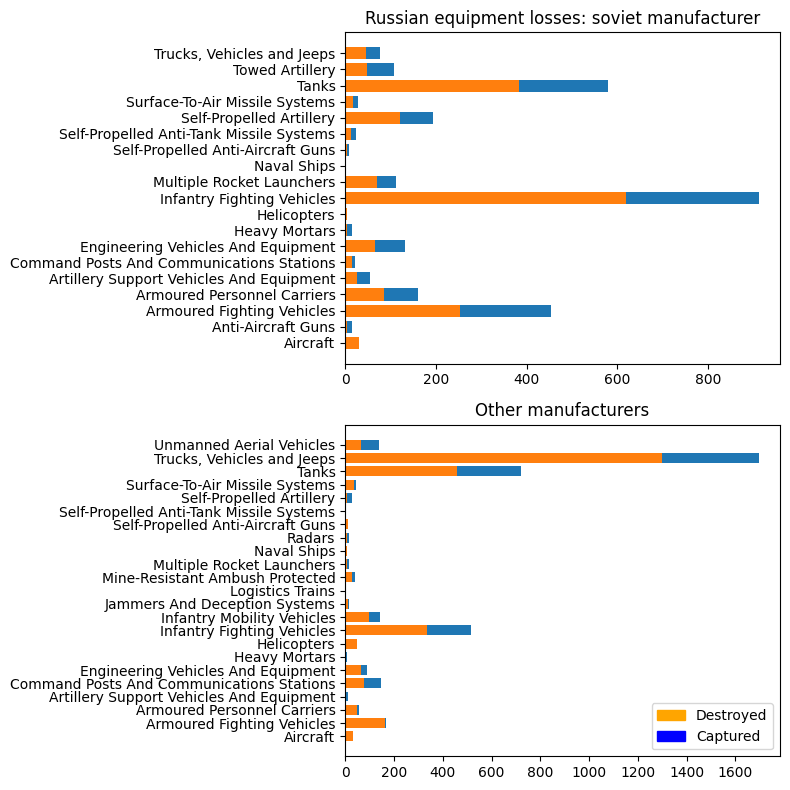

In [60]:
plt.rc("figure", figsize=(8,8)) 

fig, ax = plt.subplots(2)
for index, df in enumerate([df_tech_soviet_totals, df_tech_not_soviet_totals]):
    labels = df.index
    width = 0.75
    captured = df['total captured']
    not_captured = df['total not captured']
    ax[index].set_title('Russian equipment losses: soviet manufacturer')
    ax[index].barh(labels, captured + not_captured, width)
    ax[index].barh(labels, not_captured, width)
plt.title('Other manufacturers')
orange_patch = mpatches.Patch(color='orange', label='Destroyed')
blue_patch = mpatches.Patch(color='blue', label='Captured')
plt.legend(handles=[orange_patch, blue_patch])
plt.tight_layout()
plt.show()


- Ello concuerda con los datos obtenidos en las otras hipótesis.
- Además, podemos decir que, por norma general, la mayoría del equipamiento de un ejército moderno lo forman los vehículos terrestres, y el grueso de sus vehículos son, en efecto, automóviles blindados
- He buscado una prueba para el caso de Ucrania y Rusia: https://www.statista.com/statistics/1296573/russia-ukraine-military-comparison/
- Ojo que eso indica las capacidades militares de ambas naciones; probablemente no sabremos el número real de tropas desplegadas hasta que pase la guerra


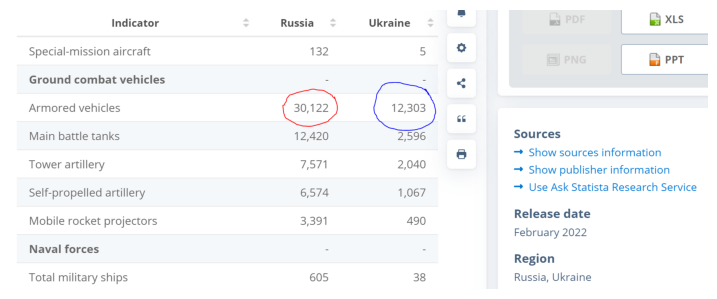

In [61]:
plt.rc("figure", figsize=(9,7)) 
img = mpimg.imread('./data/vehicles_amount.PNG')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


- Tengo que comprobar, mirando cada categoría de equipamiento, si es cierto que la proporción en capturas es superior para el equipamiento soviético respecto al equipamiento no soviético
- Lo hago con una columna que será la proporción de capturas respecto al total
- Lo preparo en forma de funciones (equalize_indexes para quitar las categorías que no son comunes y show_equipment_by_manufacturer para hacer el gráfico en sí) para repetir luego el proceso con el dataframe ucraniano
- Primero hago una función...

In [62]:
'''Removes the elements found in the index of one dataframe that do not appear in the other'''
def equalize_indexes(df_a, df_b):
    '''Requires two dataframes as positional arguments'''
    for index in df_a.index:
        if index not in df_b.index:
            df_a.drop(index=index, inplace=True)


- ...y luego, la otra. Las funciones no van a utils porque solo sirven para facilitar este proceso, no las usaré nunca más

In [63]:
'''Shows a barpot of equipment (russian or ukrainian) by manufacturer (sovietic or not sovietic)'''
def show_equipment_by_manufacturer(df_soviet, df_not_soviet, side):
    '''Requires a dataframe, a second dataframe and a string as positional arguments'''
    for df in [df_soviet, df_not_soviet]:
        df['captured P'] = (df['total captured'] / (df['total captured'] + df['total not captured'])) * 100

    equalize_indexes(df_soviet, df_not_soviet)
    equalize_indexes(df_not_soviet, df_soviet)

    plt.rc("figure", figsize=(8,4)) 
    X = np.arange(len(df_soviet['captured P']))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, list(df_soviet['captured P']), color = 'r', width = 0.25)
    ax.bar(X + 0.25, list(df_not_soviet['captured P']), color = 'b', width = 0.25)
    plt.xticks([i for i, val in enumerate(df_not_soviet.index)], df_soviet.index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.legend(labels=['% of soviet equipment captured', '% of not soviet equipment captured'])
    plt.title(f'% of {side} captured equipment by manufacturer (not destroyed)')
    plt.show()


- Preparo la gráfica para los porcentajes de equipamiento capturado de Rusia

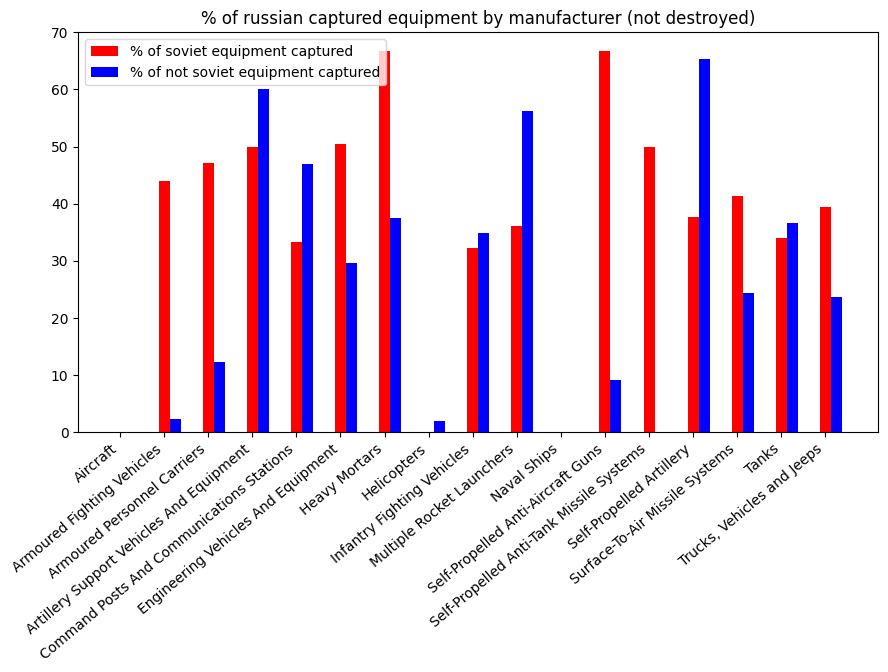

In [64]:
show_equipment_by_manufacturer(df_tech_soviet_totals, df_tech_not_soviet_totals, 'russian')


- La repito para el caso ucraniano

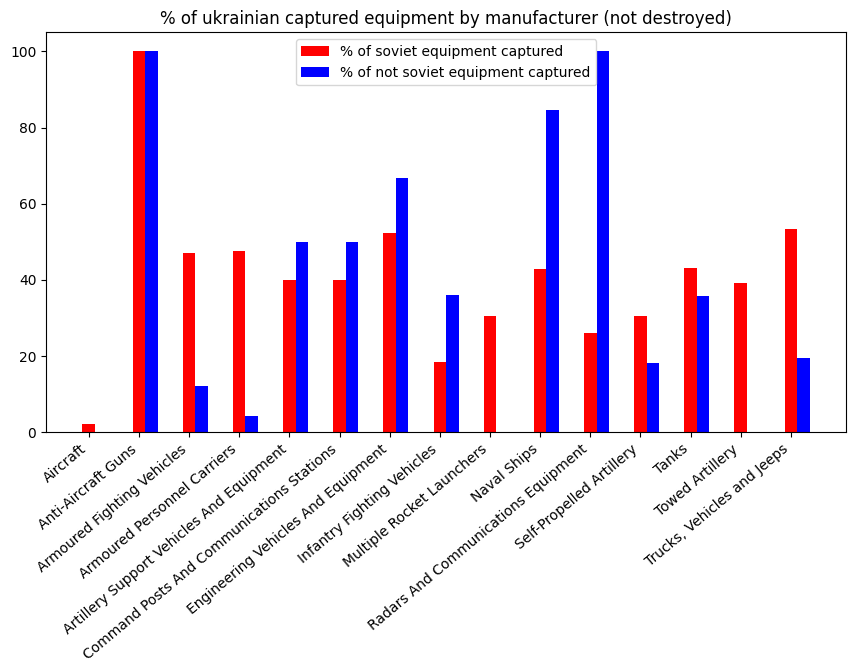

In [65]:
df_uk_tech_soviet = df_uk_tech[df_uk_tech['manufacturer'] == 'the Soviet Union']
df_uk_tech_not_soviet = df_uk_tech[df_uk_tech['manufacturer'] != 'the Soviet Union']
df_uk_tech_not_soviet_totals =df_uk_tech_not_soviet.groupby('equipment').sum(numeric_only=True)[['total captured', 'total not captured']]
df_uk_tech_soviet_totals = df_uk_tech_soviet.groupby('equipment').sum(numeric_only=True)[['total captured', 'total not captured']]
df_uk_tech_soviet_totals

show_equipment_by_manufacturer(df_uk_tech_soviet_totals, df_uk_tech_not_soviet_totals, 'ukrainian')


- Quiero ver si la media de los soviéticos o la de no soviéticos es superior, tanto para Rusia como para Ucrania
- Necesito comparar, también, los totales para Rusia y Ucrania
- Son pocos valores para cada caso, así que, tras comprobar que las varianzas son iguales, me lanzo a hacer ttests
- Todos los pvalores son superiores a 0.05, y, por tanto, iguales. Ni se capturan más (ni menos) soviéticos en ningún caso, ni hay diferencia entre lo que captura Rusia y lo que captura Ucrania


In [66]:
print('Rusia: % de capturados soviéticos vs no soviéticos')
print(Ftest(df_tech_soviet_totals['captured P'], df_tech_not_soviet_totals['captured P']))
print(stats.ttest_ind(a=df_tech_soviet_totals['captured P'],
                        b=df_tech_not_soviet_totals['captured P'],
                        equal_var=True))

print('\n')

print('Ucrania: % de capturados soviéticos vs no soviéticos')
print(Ftest(df_uk_tech_soviet_totals['captured P'], df_uk_tech_soviet_totals['captured P']))
print(stats.ttest_ind(a=df_uk_tech_soviet_totals['captured P'],
                        b=df_uk_tech_not_soviet_totals['captured P'],
                        equal_var=True))

print('\n')

print('Capturados en %: Rusia vs Ucrania')
captured_p = list(df_tech_soviet_totals['captured P']) + list(df_tech_not_soviet_totals['captured P'])
uk_captured_p = list(df_uk_tech_soviet_totals['captured P']) + list(df_uk_tech_not_soviet_totals['captured P'])
print(Ftest(captured_p, uk_captured_p))
print(stats.ttest_ind(a=captured_p,
                        b=uk_captured_p,
                        equal_var=True))


Rusia: % de capturados soviéticos vs no soviéticos
0.700303700059176
Ttest_indResult(statistic=1.5064839191231234, pvalue=0.14175197961042543)


Ucrania: % de capturados soviéticos vs no soviéticos
0.9999999999999999
Ttest_indResult(statistic=0.2238560158400564, pvalue=0.8244946892008924)


Capturados en %: Rusia vs Ucrania
0.11864440051651907
Ttest_indResult(statistic=-1.2896270413702329, pvalue=0.20197025617634634)


#### Hipótesis 3: conclusiones

- La mayoría de pérdidas del bando ruso son vehículos de transporte de infantería armados (soviéticos) y vehículos de transporte no armados (no soviéticos)
- Ambas categorías corresponden a APC y "vehicles and fuel tanks" respectivamente para el caso de la hipótesis previa
- Los ttest demuestran que no hay una diferencia palpable entre el número de capturas para el equipamiento soviético y no soviético
- Tampoco la hay en las capturas totales de Rusia respecto a las de Ucrania

## CONCLUSIONES FINALES

- A la hora de enviar medicina a las ciudades, no hace falta aplicar reducciones de precio en función de la cercanía al frente
- Hay que pedir a los aliados que envíen más antibióticos y antipiréticos con tal de bajar los precios y frenar la oscilación
- Hay que fijarse en los cambios de estrategia rusa: en el momento en que se sirvan menos de infantería (probablemente porque pasen a destruir las ciudades en lugar de tomarlas), los países colindantes deben prepararse para la posibilidad de recibir más refugiados
- La mejor manera de incrementar las bajas de personal de Rusia es atacar a sus vehículos de transporte de infantería. De entre ellos, lo más práctico es atacar a camiones y otros vehículos no blindados. Si hay que atacar a vehículos de transporte con capacidad de autodefensa, es preferible que sean APC (Armoured Personnel Carrier) antes que IFV (Infantry Fighting Vehicle). Si se atacan APC/IFV, que sean soviéticos; en caso contrario, que sean no soviéticos
- No hay que discriminar a la hora de dar uso a equipamiento soviético o no soviético; al menos, si solo se tiene en cuenta la posibilidad de que sea destruido o capturado